# Team information: DS102_Teams2

* Hien-My Nguyen
* Khanh-Linh Nguyen Phan
* Tuan-Kiet Tran
* Thanh-Linh Le Ho
* Van-Truong Vo


## 1. Visualization and understand data

In [1]:
# Standard Libraries
import os
import re
import warnings
from concurrent.futures import ThreadPoolExecutor

# Data Handling and Processing
import numpy as np
import pandas as pd
import polars as pl  # Faster alternative to Pandas for large data
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

# Machine Learning and Deep Learning Libraries
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Optimization
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from tqdm import tqdm
from colorama import Fore, Style
from IPython.display import clear_output


# Display settings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Define Severity Labels
severity_levels = ['None', 'Mild', 'Moderate', 'Severe']

# Define an Enum data type for seasonal data columns
season_enum = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

# Load and Preprocess Training Dataset
train_data = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_enum))  # Cast season-related columns to season_enum
)

# Load and Preprocess Test Dataset
test_data = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_enum))  # Cast season-related columns to season_enum
)

# Display a sample of loaded data for quick verification
print("Sample of Training Data:")
print(train_data.head())
print("\nSample of Test Data:")
print(test_data.head())


Sample of Training Data:
shape: (5, 82)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬──────┐
│ id       ┆ Basic_Demo ┆ Basic_Demo ┆ Basic_Demo ┆ … ┆ SDS-SDS_To ┆ PreInt_Edu ┆ PreInt_Ed ┆ sii  │
│ ---      ┆ s-Enroll_S ┆ s-Age      ┆ s-Sex      ┆   ┆ tal_T      ┆ Hx-Season  ┆ uHx-compu ┆ ---  │
│ str      ┆ eason      ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ terintern ┆ i64  │
│          ┆ ---        ┆ i64        ┆ i64        ┆   ┆ i64        ┆ enum       ┆ et_…      ┆      │
│          ┆ enum       ┆            ┆            ┆   ┆            ┆            ┆ ---       ┆      │
│          ┆            ┆            ┆            ┆   ┆            ┆            ┆ i64       ┆      │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪══════╡
│ 00008ff9 ┆ Fall       ┆ 5          ┆ 0          ┆ … ┆ null       ┆ Fall       ┆ 3         ┆ 2    │
│ 000fd460 ┆ Summer     ┆ 9          ┆ 0          ┆

### 1.1. Check missing and null data

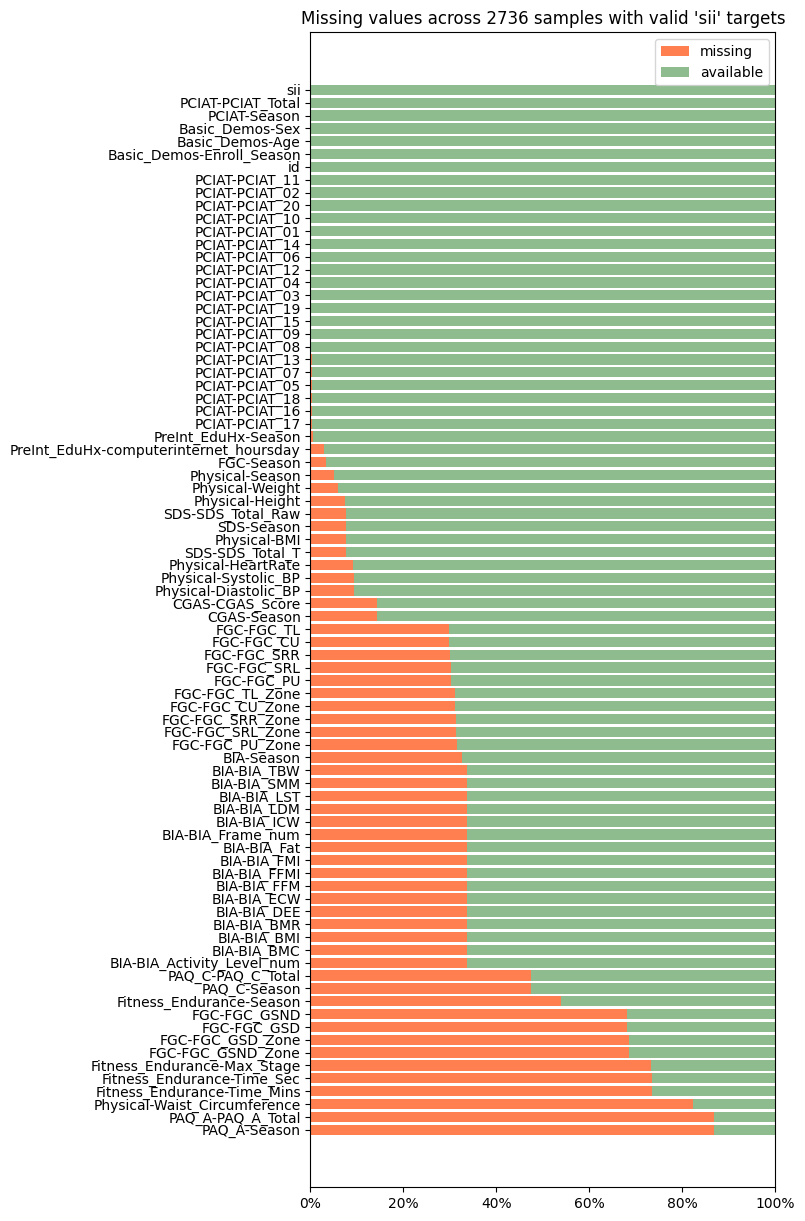

Percentage of consistent missing values between 'PCIAT-PCIAT_Total' and 'sii': 100.00%
Summary of 'PCIAT-PCIAT_Total' by 'sii' levels:
shape: (5, 4)
┌──────┬─────────────────┬─────────────────┬───────┐
│ sii  ┆ PCIAT_Total_min ┆ PCIAT_Total_max ┆ count │
│ ---  ┆ ---             ┆ ---             ┆ ---   │
│ i64  ┆ i64             ┆ i64             ┆ u32   │
╞══════╪═════════════════╪═════════════════╪═══════╡
│ null ┆ null            ┆ null            ┆ 1224  │
│ 0    ┆ 0               ┆ 30              ┆ 1594  │
│ 1    ┆ 31              ┆ 49              ┆ 730   │
│ 2    ┆ 50              ┆ 79              ┆ 378   │
│ 3    ┆ 80              ┆ 93              ┆ 34    │
└──────┴─────────────────┴─────────────────┴───────┘


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Step 1: Filter out rows with missing 'sii' values for supervised learning
filtered_data = train_data.filter(pl.col('sii').is_not_null())

# Step 2: Calculate missing values per feature
missing_values = (
    filtered_data
    .null_count()
    .transpose(include_header=True, header_name='feature', column_names=['missing_count'])
    .sort('missing_count', descending=True)
    .with_columns((pl.col('missing_count') / len(filtered_data)).alias('missing_ratio'))
)

# Step 3: Plot missing value ratios for features
plt.figure(figsize=(6, 15))
plt.title(f"Missing values across {len(filtered_data)} samples with valid 'sii' targets")

# Plot bars for missing and available values
plt.barh(np.arange(len(missing_values)), missing_values.get_column('missing_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_values)), 
         1 - missing_values.get_column('missing_ratio'),
         left=missing_values.get_column('missing_ratio'),
         color='darkseagreen', label='available')

# Customize plot appearance
plt.yticks(np.arange(len(missing_values)), missing_values.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

# Step 4: Check if 'PCIAT-PCIAT_Total' missing values align with 'sii' missing values
pciat_sii_match_ratio = train_data.select((pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null())).to_series().mean()
print(f"Percentage of consistent missing values between 'PCIAT-PCIAT_Total' and 'sii': {pciat_sii_match_ratio * 100:.2f}%")

# Step 5: Group by 'sii' to find min, max, and count of 'PCIAT-PCIAT_Total' within each 'sii' level
pciat_summary_by_sii = (
    train_data
    .select(pl.col('PCIAT-PCIAT_Total'))
    .group_by(train_data.get_column('sii'))
    .agg([
        pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT_Total_min'),
        pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT_Total_max'),
        pl.col('PCIAT-PCIAT_Total').len().alias('count')
    ])
    .sort('sii')
)

print("Summary of 'PCIAT-PCIAT_Total' by 'sii' levels:")
print(pciat_summary_by_sii)


In [3]:
# Checking Class Imbalance in the Target Variable
print("Note: This dataset is imbalanced, with a significant number of samples in class 0 and very few in class 3.")

# Identifying Columns Present in Training Data but Missing in Test Data
missing_in_test = [col for col in train_data.columns if col not in test_data.columns]
print("Columns present in training data but missing in test data:")
print(missing_in_test)


Note: This dataset is imbalanced, with a significant number of samples in class 0 and very few in class 3.
Columns present in training data but missing in test data:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


### 1.2. Visualize tabular data

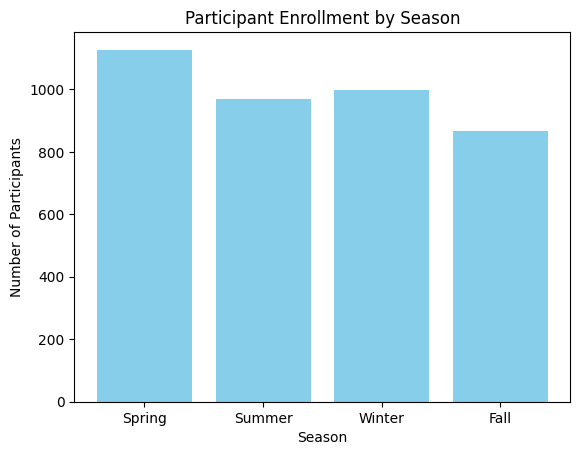

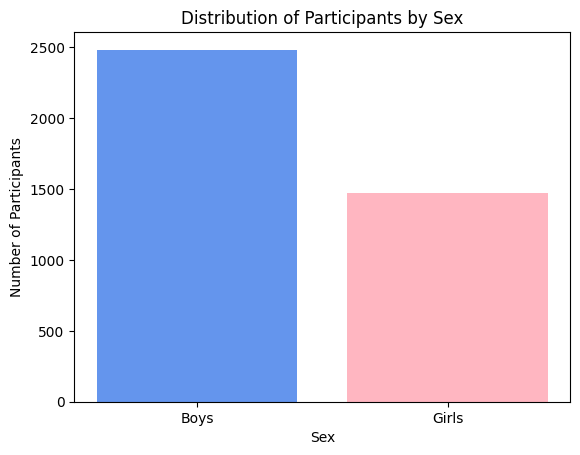

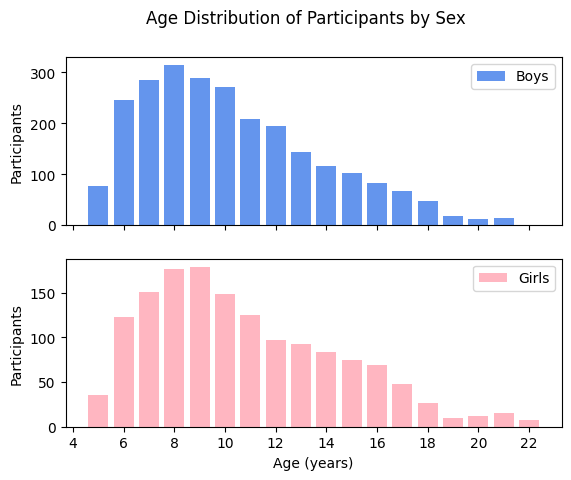

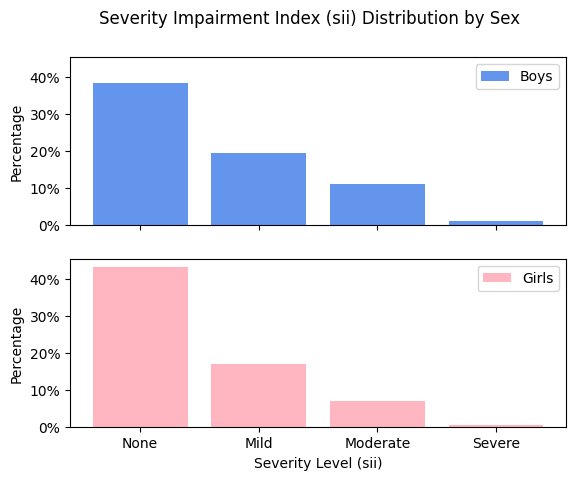

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter, MaxNLocator

# Plot Enrollment Season Distribution (using a bar chart for clearer comparison)
enroll_season_counts = train_data.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.figure()
plt.bar(enroll_season_counts.get_column('Basic_Demos-Enroll_Season'), enroll_season_counts.get_column('count'), color='skyblue')
plt.title('Participant Enrollment by Season')
plt.xlabel('Season')
plt.ylabel('Number of Participants')
plt.show()

# Plot Sex Distribution of Participants (using a bar chart for clarity)
sex_counts = train_data.get_column('Basic_Demos-Sex').value_counts()
plt.figure()
plt.bar(['Boys', 'Girls'], sex_counts.get_column('count'), color=['cornflowerblue', 'lightpink'])
plt.title('Distribution of Participants by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Participants')
plt.show()

# Plot Age Distribution by Sex (using histograms for better age grouping)
fig, age_axes = plt.subplots(2, 1, sharex=True)
for gender in range(2):  # 0 for boys, 1 for girls
    ax = age_axes[gender]
    age_counts = train_data.filter(pl.col('Basic_Demos-Sex') == gender).get_column('Basic_Demos-Age').value_counts()
    ax.bar(age_counts.get_column('Basic_Demos-Age'),
           age_counts.get_column('count'),
           color=['cornflowerblue', 'lightpink'][gender],
           label=['Boys', 'Girls'][gender])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Participants')
    ax.legend()
fig.suptitle('Age Distribution of Participants by Sex')
age_axes[1].set_xlabel('Age (years)')
plt.show()

# Plot Severity Impairment Index (sii) Distribution by Sex (using a stacked bar chart for normalized percentages)
fig, sii_axes = plt.subplots(2, 1, sharex=True, sharey=True)
for gender in range(2):  # 0 for boys, 1 for girls
    ax = sii_axes[gender]
    sii_counts = train_data.filter(pl.col('Basic_Demos-Sex') == gender).get_column('sii').value_counts()
    ax.bar(sii_counts.get_column('sii'),
           sii_counts.get_column('count') / sii_counts.get_column('count').sum(),
           color=['cornflowerblue', 'lightpink'][gender],
           label=['Boys', 'Girls'][gender])
    ax.set_xticks(np.arange(4), severity_levels)  # severity_levels corresponds to ['None', 'Mild', 'Moderate', 'Severe']
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('Percentage')
    ax.legend()
fig.suptitle('Severity Impairment Index (sii) Distribution by Sex')
sii_axes[1].set_xlabel('Severity Level (sii)')
plt.show()


### 1.3. Understand actigraphy data

shape: (287_179, 13)
┌────────┬───────────┬───────────┬───────────┬───┬──────────────┬─────────┬─────────┬──────────────┐
│ step   ┆ X         ┆ Y         ┆ Z         ┆ … ┆ time_of_day  ┆ weekday ┆ quarter ┆ relative_dat │
│ ---    ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---          ┆ ---     ┆ ---     ┆ e_PCIAT      │
│ u32    ┆ f32       ┆ f32       ┆ f32       ┆   ┆ i64          ┆ i8      ┆ i8      ┆ ---          │
│        ┆           ┆           ┆           ┆   ┆              ┆         ┆         ┆ f32          │
╞════════╪═══════════╪═══════════╪═══════════╪═══╪══════════════╪═════════╪═════════╪══════════════╡
│ 0      ┆ 0.014375  ┆ -0.020112 ┆ -0.995358 ┆ … ┆ 441000000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 1      ┆ 0.014167  ┆ -0.023278 ┆ -0.996164 ┆ … ┆ 441050000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆     

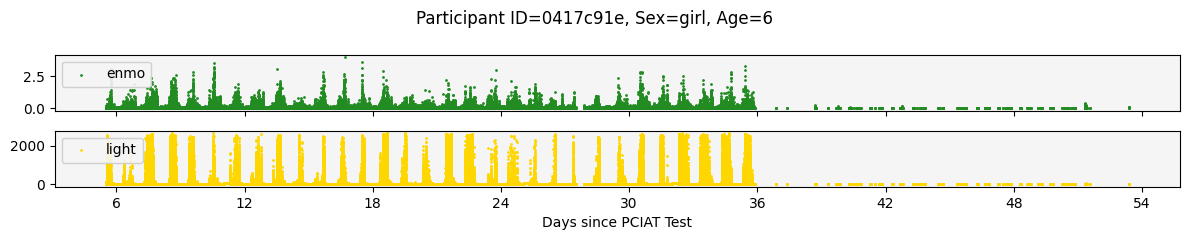

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Load the initial actigraphy data for verification
actigraphy_sample = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
print(actigraphy_sample)

# Define the function to analyze and visualize actigraphy data
def analyze_actigraphy(participant_id, one_week_only=False, minimal_features=False):
    # Load the specific participant's actigraphy data
    actigraphy_data = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={participant_id}/part-0.parquet')
    
    # Calculate the "day" based on relative PCIAT test date and time of day
    days_since_test = actigraphy_data.get_column('relative_date_PCIAT') + actigraphy_data.get_column('time_of_day') / 86400e9
    
    # Retrieve age and sex information for participant
    participant_info = train_data.filter(pl.col('id') == participant_id)
    age = participant_info.get_column('Basic_Demos-Age').item()
    sex = 'boy' if participant_info.get_column('Basic_Demos-Sex').item() == 0 else 'girl'
    
    # Add computed features: time differences and acceleration norm
    actigraphy_data = (
        actigraphy_data
        .with_columns(
            (days_since_test.diff() * 86400).alias('time_diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z')))).alias('accel_norm')
        )
    )
    
    # Apply data mask based on whether only one week of data is desired
    if one_week_only:
        start_day = np.ceil(days_since_test.min())
        mask = (start_day <= days_since_test.to_numpy()) & (days_since_test.to_numpy() <= start_day + 7)
        mask &= ~actigraphy_data.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.ones(len(days_since_test), dtype=bool)  # Use all data if one_week_only is False

    # Select features to plot based on the minimal_features flag
    if minimal_features:
        feature_list = [
            ('enmo', 'forestgreen'),
            ('light', 'gold'),
        ]
    else:
        feature_list = [
            ('X', 'mediumslateblue'),
            ('Y', 'deepskyblue'),
            ('Z', 'dodgerblue'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'gold'),
            ('non-wear_flag', 'darkorange')
        ]

    # Plot each selected feature over time
    fig, axes = plt.subplots(len(feature_list), 1, sharex=True, figsize=(12, len(feature_list) * 1.2))
    for ax, (feature, color) in zip(axes, feature_list):
        ax.set_facecolor('#f5f5f5')
        ax.scatter(days_since_test.to_numpy()[mask],
                   actigraphy_data.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#f5f5f5', framealpha=0.9)
        if feature == 'time_diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    
    # Set titles and labels
    fig.suptitle(f'Participant ID={participant_id}, Sex={sex}, Age={age}')
    axes[-1].set_xlabel('Days since PCIAT Test')
    axes[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# Test the function with participant ID and settings
analyze_actigraphy('0417c91e', one_week_only=False, minimal_features=True)

# Set seed and define number of splits for cross-validation (if needed later)
SEED = 42
n_splits = 5


## 2. Test with method 1

### 2.1. Preprocessing

In [6]:
# Load data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df



In [7]:
# Merge and Drop Columns
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


In [8]:
# Select Relevant Features and Handle Missing Values
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

### 2.2. Feature Extraction 

In [9]:
# Feature Extraction 

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)


### 2.3. Training model

In [10]:

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)


In [11]:
SEED = 42
n_splits = 5

In [12]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        clear_output(wait=True)

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission


In [13]:
# Parameters 

Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01  
}



XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5,  
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  
}


from collections import Counter

# Tính toán trọng số lớp
class_counts = Counter(train['sii'])  # Số lượng mẫu trong từng lớp
total_samples = len(train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Áp dụng trọng số vào tham số LightGBM
Params_with_weights = {
    **Params,
    'class_weight': class_weights
}

# Khởi tạo mô hình LightGBM với trọng số lớp
Light = LGBMRegressor(**Params_with_weights, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)



voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission1 = TrainML(voting_model, test)

Submission1

Training Folds: 100%|██████████| 5/5 [01:49<00:00, 21.98s/it]


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,1


## 2. Test with method2

### 2.1. Preprocessing 

In [14]:
# Load data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')



In [15]:
# Merge and Drop Columns# 
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)  

100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


In [16]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    return df

In [17]:
imputer = KNNImputer(n_neighbors=5)

In [18]:
numeric_cols = train.select_dtypes(include=['int32', 'int64', 'float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [19]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR
0,5.0,0.0,51.0,16.877316,46.0,50.80,27.6,68.4,86.4,107.2,5.4,7.0,28.2,0.0,0.0,20.160,1.8,23.60,2.2,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,2.2140,3.066,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,43.0,60.4,3.0,2,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,-0.080116,0.005348,-0.283335,0.045798,-25.083364,0.467937,36.006484,3845.511670,4.394847e+13,3.977370,2.290452,25.595923,0.368646,0.416894,0.488638,0.106046,36.918335,0.246058,97.869340,151.775882,2.334072e+13,1.953752,0.231794,7.265953,-2.118327,-2.019356,-1.052139,0.000002,-89.262643,0.0,0.0,3183.333398,0.000000e+00,1.0,1.8,13.0,-0.318849,-0.352264,-0.717070,0.005901,-56.925185,0.200000,1.169628,3753.216650,2.396550e+13,2.0,2.4,19.2,-0.126845,0.046864,-0.246851,0.015284,-19.725564,0.6,3.654625,3817.650000,4.419550e+13,4.0,2.4,25.6,0.160487,0.305664,0.016108,0.040101,-3.859512,0.6,11.600000,3955.63335,6.392825e+13,5.8,2.4,31.6,1.397385,2.416911,1.837962,3.252203,86.678120,0.8,1333.363339,4162.2,8.639500e+13,7.0,2.4,39.0,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,1458.200076
1,9.0,0.0,65.4,14.035590,48.0,46.00,22.0,75.0,70.0,122.0,5.0,9.4,24.4,3.0,0.0,16.280,1.6,17.68,1.6,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,1.8400,2.340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,-0.080116,0.005348,-0.283335,0.045798,-25.083364,0.467937,36.006484,3845.511670,4.394847e+13,3

In [20]:

# train = feature_engineering(train)
# test = feature_engineering(test)

In [21]:
#  Select Relevant Features and Handle Missing Values: 
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight', 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

#  Select Relevant Features and Handle Missing Values: 
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight', 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR']

featuresCols += time_series_cols
test = test[featuresCols]

In [22]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,5.0,0.0,51.0,16.877316,46.0,50.80,27.6,68.4,86.4,107.2,5.4,7.0,28.2,0.0,0.0,20.160,1.8,23.60,2.2,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,2.2140,3.066,43.0,60.4,3.0,2,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,1458.200076,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,-0.080116,0.005348,-0.283335,0.045798,-25.083364,0.467937,36.006484,3845.511670,4.394847e+13,3.977370,2.290452,25.595923,0.368646,0.416894,0.488638,0.106046,36.918335,0.246058,97.869340,151.775882,2.334072e+13,1.953752,0.231794,7.265953,-2.118327,-2.019356,-1.052139,0.000002,-89.262643,0.0,0.0,3183.333398,0.000000e+00,1.0,1.8,13.0,-0.318849,-0.352264,-0.717070,0.005901,-56.925185,0.200000,1.169628,3753.216650,2.396550e+13,2.0,2.4,19.2,-0.126845,0.046864,-0.246851,0.015284,-19.725564,0.6,3.654625,3817.650000,4.419550e+13,4.0,2.4,25.6,0.160487,0.305664,0.016108,0.040101,-3.859512,0.6,11.600000,3955.63335,6.392825e+13,5.8,2.4,31.6,1.397385,2.416911,1.837962,3.252203,86.678120,0.8,1333.363339,4162.2,8.639500e+13,7.0,2.4,39.0
1,9.0,0.0,65.4,14.035590,48.0,46.00,22.0,75.0,70.0,122.0,5.0,9.4,24.4,3.0,0.0,16.280,1.6,17.68,1.6,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,1.8400,2.340,46.0,64.0,0.0,0,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,-0.080116,0.005348,-0.283335,0.045798,-25.083364,0.467937,36.006484,3845.511670,4.394847e+13,3.977370,2.290452,25.595923,0.368646,0.416894,0.488638,0.106046,36.918335,0.246058,97.869340,151.775882,2.334072e+13,1.953752,0.231794,7.265953,-2.118327,-2.019356,-1.052139,0.000002,-89.262643,0.0,0.0,3183.333398,0.000000e+00,1.0,1.8,13.0,-0.318849,-0.352264,-0.717070,0.005901,-56.925185,0.200000,1.169628,3753.216650,2.396550e+13,2.0

In [23]:
test

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,5,0,51.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,0,NaN,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,71.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,166.486961,20.0,33.297392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1564.977430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9

### 2.2. Feature Extraction

In [24]:


# for col in cat_c:
#     mapping = create_mapping(col, train)
#     mappingTe = create_mapping(col, test)
    
#     train[col] = train[col].replace(mapping).astype(int)
#     test[col] = test[col].replace(mappingTe).astype(int)

if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

In [25]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,5.0,0.0,51.0,16.877316,46.0,50.80,27.6,68.4,86.4,107.2,5.4,7.0,28.2,0.0,0.0,20.160,1.8,23.60,2.2,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.668550,16.87920,932.4980,1492.000,8.255980,41.58620,13.81770,3.061430,9.213770,1.0,24.43490,8.895360,38.91770,19.54130,32.69090,2.2140,3.066,43.0,60.4,3.0,2,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,1458.200076,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,-0.080116,0.005348,-0.283335,0.045798,-25.083364,0.467937,36.006484,3845.511670,4.394847e+13,3.977370,2.290452,25.595923,0.368646,0.416894,0.488638,0.106046,36.918335,0.246058,97.869340,151.775882,2.334072e+13,1.953752,0.231794,7.265953,-2.118327,-2.019356,-1.052139,0.000002,-89.262643,0.0,0.0,3183.333398,0.000000e+00,1.0,1.8,13.0,-0.318849,-0.352264,-0.717070,0.005901,-56.925185,0.200000,1.169628,3753.216650,2.396550e+13,2.0,2.4,19.2,-0.126845,0.046864,-0.246851,0.015284,-19.725564,0.6,3.654625,3817.650000,4.419550e+13,4.0,2.4,25.6,0.160487,0.305664,0.016108,0.040101,-3.859512,0.6,11.600000,3955.63335,6.392825e+13,5.8,2.4,31.6,1.397385,2.416911,1.837962,3.252203,86.678120,0.8,1333.363339,4162.2,8.639500e+13,7.0,2.4,39.0
1,9.0,0.0,65.4,14.035590,48.0,46.00,22.0,75.0,70.0,122.0,5.0,9.4,24.4,3.0,0.0,16.280,1.6,17.68,1.6,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.579490,14.03710,936.6560,1498.650,6.019930,42.02910,12.82540,1.211720,3.970850,1.0,21.03520,14.974000,39.44970,15.41070,27.05520,1.8400,2.340,46.0,64.0,0.0,0,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,382919.8,-0.080116,0.005348,-0.283335,0.045798,-25.083364,0.467937,36.006484,3845.511670,4.394847e+13,3.977370,2.290452,25.595923,0.368646,0.416894,0.488638,0.106046,36.918335,0.246058,97.869340,151.775882,2.334072e+13,1.953752,0.231794,7.265953,-2.118327,-2.019356,-1.052139,0.000002,-89.262643,0.0,0.0,3183.333398,0.000000e+00,1.0,1.8,13.0,-0.318849,-0.352264,-0.717070,0.005901,-56.925185,0.200000,1.169628,3753.216650,2.396550e+13,2.0

### 2.3. Training model

In [26]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        
        clear_output(wait=True)

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tp_rounded


In [27]:
# Ensemble Model
imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

Submission2 = TrainML(ensemble, test)

Training Folds: 100%|██████████| 5/5 [03:53<00:00, 46.71s/it]


In [28]:
Submission2 = pd.DataFrame({
    'id': sample['id'],
    'sii': Submission2
})

Submission2

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,1
8,0069fbed,1
9,0083e397,0


# Submission

In [29]:
sub1 = Submission1
sub2 = Submission2

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii']
})

def majority_vote(row):
    return row.mode()[0] if len(row.mode()) == 1 else row.mean().round().astype(int)

combined['final_sii'] = combined[['sii_1', 'sii_2']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})
final_submission.to_csv('submission.csv', index=False)